In [1]:
import sys
sys.path.append("/Users/andrei/Desktop/Repos/BBAttacks/attacks/")
sys.path.append("/Users/andrei/Desktop/Repos/BBAttacks/utils/")

import utils
from data_manager import load_data

# Black Box Attacks
import random_noise
import EvoStrategy
import SimbaWrapper

/Users/andrei/miniconda3/envs/tf/lib/python3.10/site-packages/tensorflow/python/framework/dtypes.py:246: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
/Users/andrei/miniconda3/envs/tf/lib/python3.10/site-packages/botocore/httpsession.py:41: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from urllib3.contrib.pyopenssl import orig_util_SSLContext as SSLContext


In [2]:
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from tensorflow.keras.datasets import cifar100
from tensorflow.keras import backend as K
from tensorflow import keras as keras
import tensorflow as tf
import json
import time
import datetime
from pathlib import Path
from tqdm import tqdm
import sys
import lightgbm as lgb
import optuna
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split

/Users/andrei/miniconda3/envs/tf/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cifar_100_classes = ["apple", "aquarium_fish", "baby", "bear", "beaver", "bed", "bee", "beetle", "bicycle", "bottle", "bowl", "boy", "bridge", "bus", "butterfly", "camel", "can", "castle", "caterpillar", "cattle", "chair", "chimpanzee", "clock", "cloud", "cockroach", "couch", "cra", "crocodile", "cup", "dinosaur", "dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster", "house", "kangaroo", "keyboard", "lamp", "lawn_mower", "leopard", "lion", "lizard", "lobster", "man", "maple_tree", "motorcycle", "mountain", "mouse", "mushroom", "oak_tree", "orange", "orchid", "otter", "palm_tree", "pear", "pickup_truck", "pine_tree", "plain", "plate", "poppy", "porcupine", "possum", "rabbit", "raccoon", "ray", "road", "rocket", "rose", "sea", "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider", "squirrel", "streetcar", "sunflower", "sweet_pepper", "table", "tank", "telephone", "television", "tiger", "tractor", "train", "trout", "tulip", "turtle", "wardrobe", "whale", "willow_tree", "wolf", "woman", "worm"]

<h3> Loading model and data </h3>

In [4]:
CIFAR100_VGG_PATH = "/Users/andrei/Desktop/Repos/cifar-vgg/"
sys.path.append(CIFAR100_VGG_PATH)
import cifar100vgg

In [5]:
importlib.reload(cifar100vgg)
model = cifar100vgg.cifar100vgg(train=False)

NUM_CLASSES = 100

In [6]:
LOAD_DATA = True
SAVE_DATA = False

In [7]:
if LOAD_DATA:
    (x_train, y_train), (x_test, y_test) = cifar100.load_data()

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)
    
    if SAVE_DATA:
        np.save("x_test.npy", x_test)
        np.save("y_test.npy", y_test)

In [8]:
x_train = x_train.astype('int')
x_test = x_test.astype('int')

In [9]:
import gc
gc.collect()

886

In [10]:
%%time
preds_train = model.predict(x_train)

2023-11-02 16:07:26.783344: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


CPU times: user 9min 14s, sys: 31.8 s, total: 9min 46s
Wall time: 1min 19s


In [11]:
preds_train_labels = np.argmax(preds_train, axis=1)

In [12]:
true_train_labels = np.argmax(y_train, axis=1)

In [13]:
acc_train = np.mean(true_train_labels == preds_train_labels)

In [14]:
acc_train

0.99638

In [15]:
preds = model.predict(x_test)

In [16]:
pred_labels = np.argmax(preds, axis=1)
true_labels = np.argmax(y_test, axis=1)
acc = np.sum(pred_labels == true_labels) / len(y_test)
print("Accuracy: ", acc)

In [20]:
# Extracting correctly classified test samples
x_test_correct = x_test[pred_labels == true_labels]
y_test_correct = y_test[pred_labels == true_labels]

In [152]:
test_class_correct_mask = (pred_labels == true_labels)

<h3> Intermediary layers utils </h3>

In [21]:
def get_intermediate_outputs(model, batch_input):
    intermediate_layer_names = [layer.name for layer in model.model.layers] 
    
    intermediate_layers_model = [
        keras.Model(
            inputs=model.model.input, 
            outputs=model.model.get_layer(layer_name).output,
        ) for layer_name in intermediate_layer_names
    ]
    
    normalized_batch = model.normalize_production(batch_input)
        
    intermediate_batch_outputs = [intermediate_layer_model(normalized_batch) for intermediate_layer_model in intermediate_layers_model]
    
    # return np.array(intermediate_batch_outputs)
    return intermediate_batch_outputs

In [22]:
def plot_layer_to_max_rel_change(interm_outputs_1, interm_outputs_2, show=True):
    interm_outputs_delta = []
    
    for layer in range(len(interm_outputs_1)):
        interm_outputs_delta.append(interm_outputs_2[layer] - interm_outputs_1[layer])
    
    layer_to_max_rel_change = []
    for layer in range(len(interm_outputs_1)):
        max_change_curr_layer = (np.sum(np.abs(interm_outputs_delta[layer][0]))/np.sum(np.abs(interm_outputs_1[layer][0])))
        layer_to_max_rel_change.append(max_change_curr_layer)
    
    if show:
        plt.figure(figsize=(8,6))
        plt.plot(layer_to_max_rel_change)
        plt.show()
    
    return layer_to_max_rel_change

In [23]:
def get_layer_outputs(model, batch_input, layer_index):
    intermediate_layer_names = [layer.name for layer in model.model.layers] 
    
    layer_name = intermediate_layer_names[layer_index]
    
    intermediate_layer_model = keras.Model(
        inputs=model.model.input, 
        outputs=model.model.get_layer(layer_name).output,
    )
    
    normalized_batch = model.normalize_production(batch_input)
    
    intermediate_batch_outputs = intermediate_layer_model(normalized_batch)
    
    # return np.array(intermediate_batch_outputs)
    return intermediate_batch_outputs

<h3> Run EvoBA against the neural network </h3>

In [24]:
importlib.reload(EvoStrategy)

<module 'EvoStrategy' from '/Users/andrei/Desktop/Repos/BBAttacks/attacks/EvoStrategy.py'>

In [203]:
GENERATION_SIZE = 30
PIXEL_COUNT = 1
STEPS = 80

adv_evo_strategy = {}

# SIZE = len(x_test_correct)
SIZE = 100
VERBOSE = False

perturbed_images = 0
failed_images = 0
queries = []


for index in tqdm(range(SIZE)):
    if test_class_correct_mask[index]:
        img = x_test[index]
        label = np.argmax(y_test[index])
        adv_evo_strategy[index] = EvoStrategy.AdversarialPerturbationEvoStraegy(
            model=model,
            img=img,
            label=label,
            generation_size=GENERATION_SIZE, 
            one_step_perturbation_pixel_count=PIXEL_COUNT,
            verbose=VERBOSE,
            zero_one_scale=False
        )
        no_steps = adv_evo_strategy[index].run_adversarial_attack(steps=STEPS)
        if adv_evo_strategy[index].is_perturbed() and no_steps > 0:
            perturbed_images += 1
            queries.append(adv_evo_strategy[index].queries)
        else:
            failed_images += 1
            queries.append(-1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.67it/s]


<h3> Plot relative perturbation per layer of the EvoBA adversarial samples </h3>

In [159]:
interm_outputs_modif = {}
interm_outputs = {}

In [160]:
plot_arrays = {}

In [30]:
SAMPLE_SIZE_INTERM = SIZE

In [177]:
# for index_diff in range(RESTART_INDEX, SIZE):
for index_diff in tqdm(range(SAMPLE_SIZE_INTERM)):
    if test_class_correct_mask[index_diff]:
        modif_img = adv_evo_strategy[index_diff].get_best_candidate()
        orig_img = x_test[index_diff]

        # modif_img_normalized_array = model.normalize_production(np.array([modif_img]).astype(float))
        # orig_img_normalized_array = model.normalize_production(np.array([orig_img]).astype(float))

        interm_outputs_modif[index_diff] = get_intermediate_outputs(model, np.array([modif_img]).astype(float))
        interm_outputs[index_diff] = get_intermediate_outputs(model, np.array([orig_img]).astype(float))

        plot_arrays[index_diff] = plot_layer_to_max_rel_change(
            interm_outputs[index_diff], 
            interm_outputs_modif[index_diff],
            show=False
        )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.30it/s]


In [178]:
# for index_diff in tqdm(range(RESTART_INDEX, SIZE)):
for index_diff in range(SAMPLE_SIZE_INTERM):
    if test_class_correct_mask[index_diff]:
        plot_arrays[index_diff] = plot_layer_to_max_rel_change(
            interm_outputs[index_diff], 
            interm_outputs_modif[index_diff],
            show=False
        )

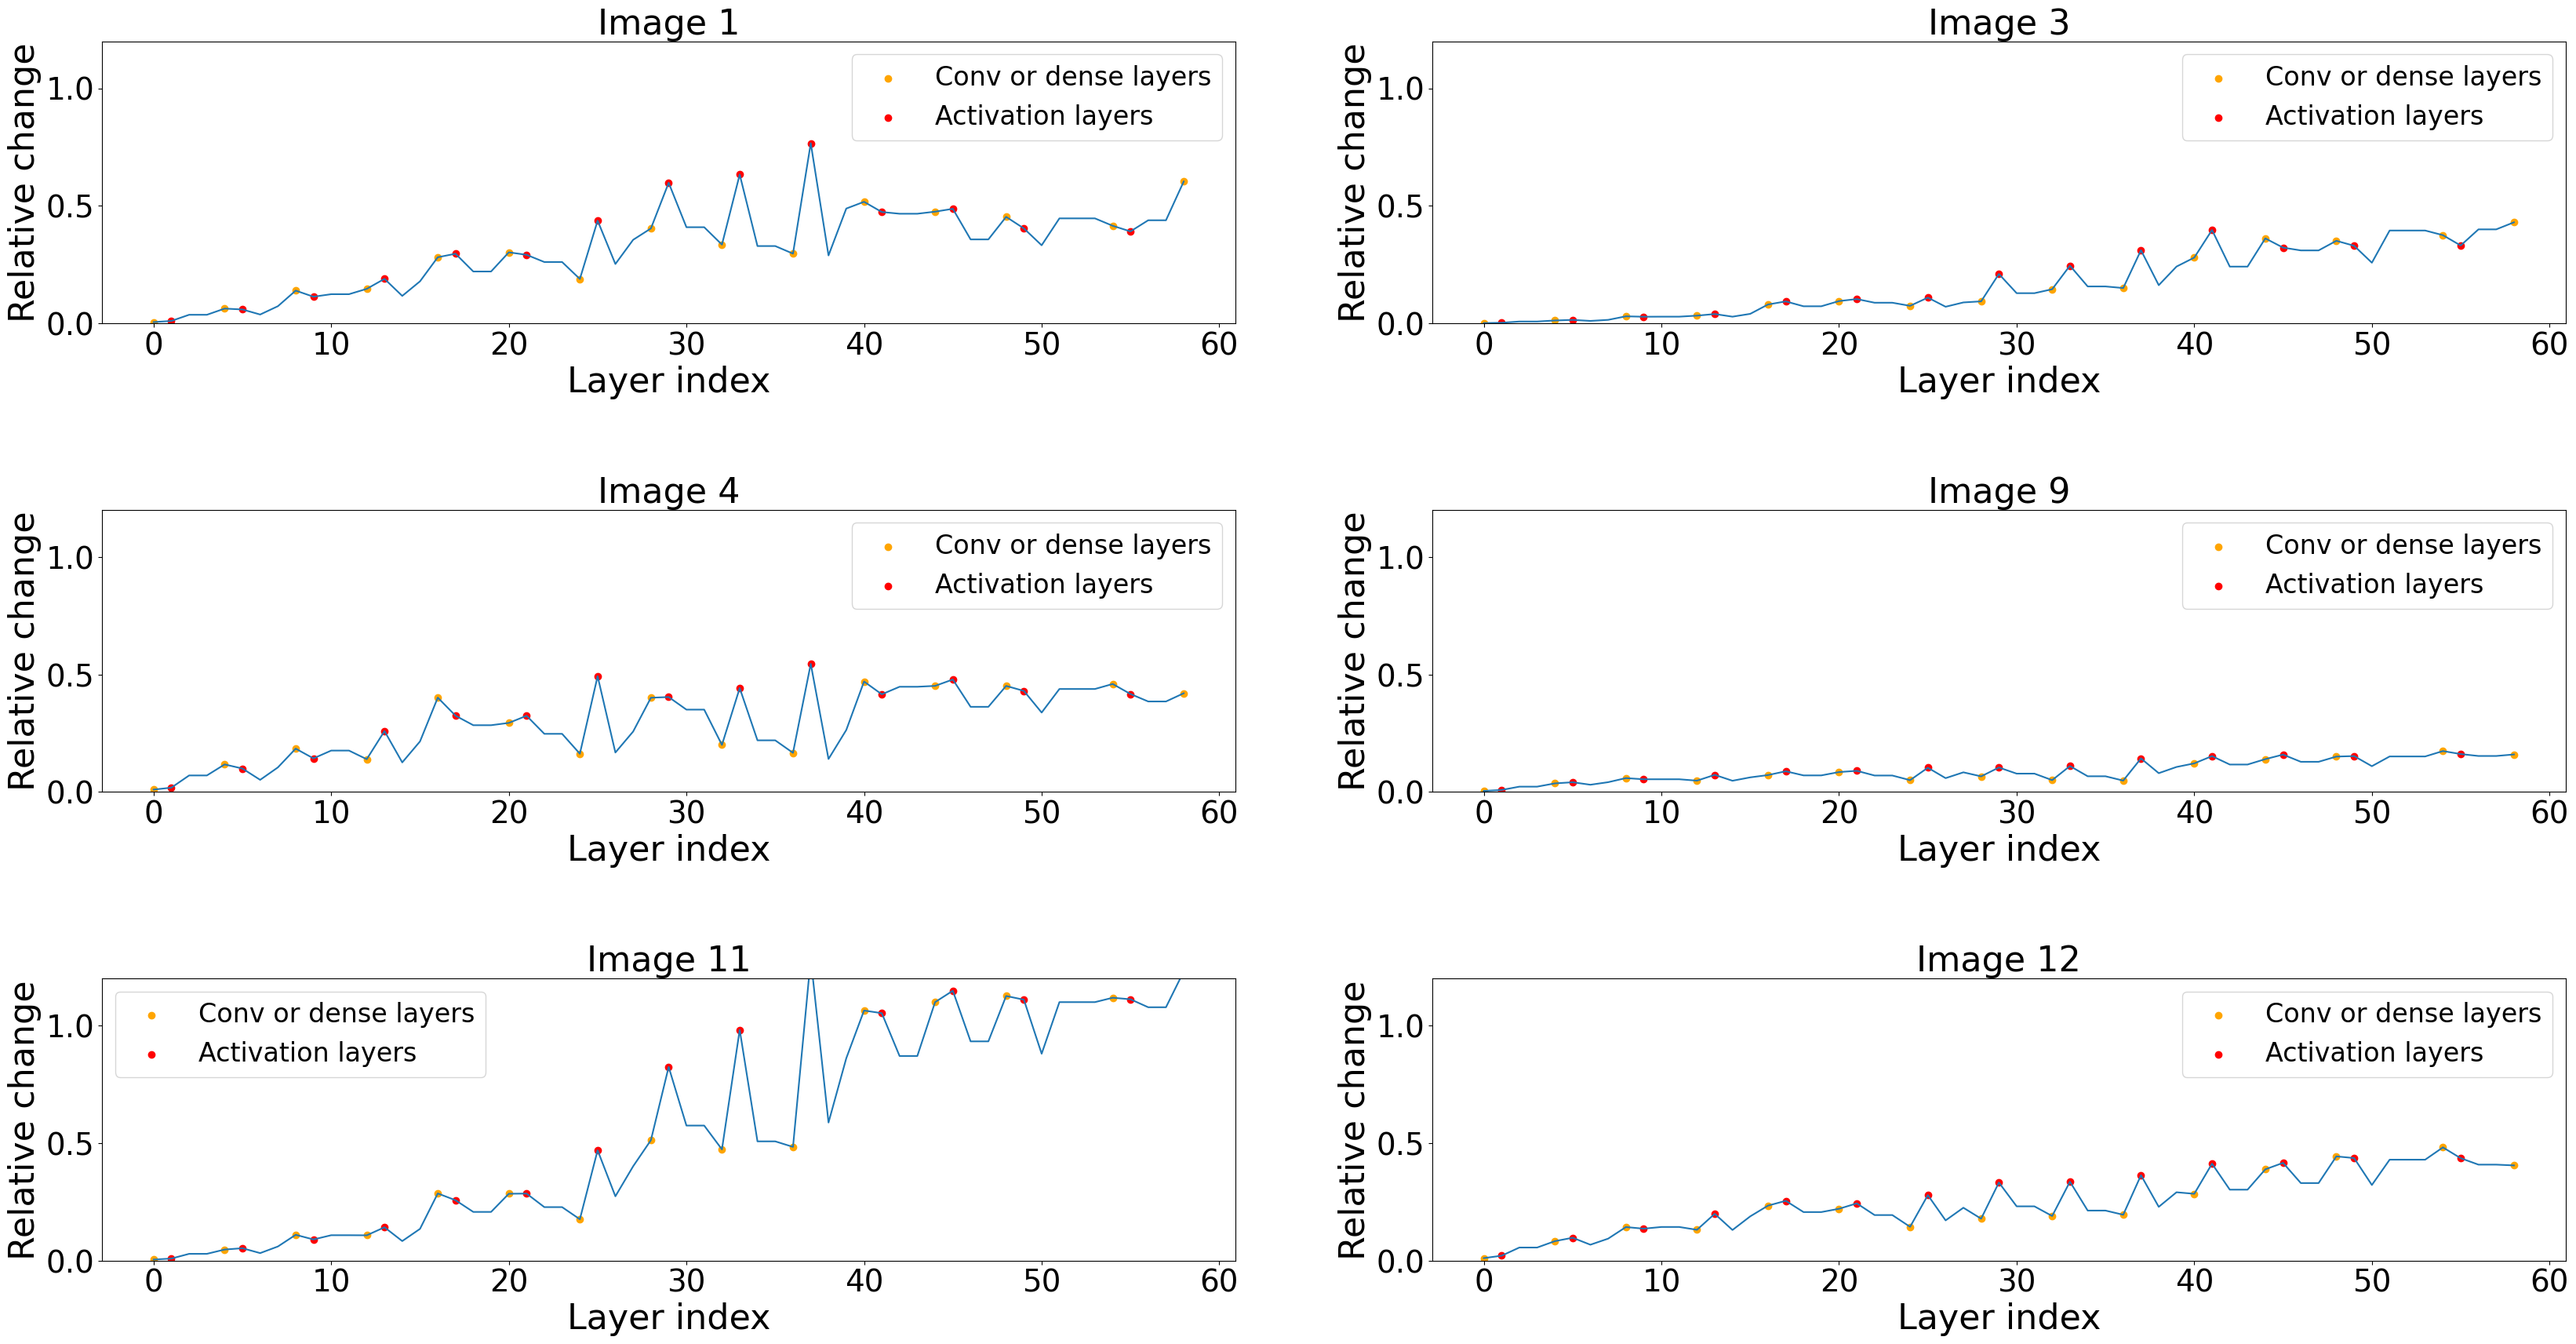

In [179]:
COLS = 2
ROWS = 3

FONTSIZE = 32
FONTSIZE_AXIS = 28
FONTSIZE_LEGEND = 24

fig, axs = plt.subplots(ROWS, COLS, figsize=(ROWS * 12,COLS * 10), )
fig.tight_layout(pad=15.0)

for i in range(ROWS):
    for j in range(COLS):
        
        avg_changes_linear = []
        indices_linear = []

        avg_changes_activation = []
        indices_activation = []
        
        img_index = list(plot_arrays.keys())[i * COLS + j]
        
        for index, layer in enumerate(model.model.layers[:-1]):
            if layer.name.startswith("conv") or layer.name.startswith("dense"):
                avg_changes_linear.append(plot_arrays[img_index][index])
                indices_linear.append(index)
            elif layer.name.startswith("activ"):
                avg_changes_activation.append(plot_arrays[img_index][index])        
                indices_activation.append(index)
                
        axs[i,j].set_title(f"Image {img_index}", fontsize=FONTSIZE)
        axs[i,j].set_ylim(0, 1.2)
        axs[i,j].plot(plot_arrays[img_index][:-1])
        axs[i,j].set_xlabel("Layer index", fontsize=FONTSIZE)
        axs[i,j].set_ylabel("Relative change", fontsize=FONTSIZE)
        
        axs[i,j].xaxis.set_tick_params(labelsize=FONTSIZE_AXIS)
        axs[i,j].yaxis.set_tick_params(labelsize=FONTSIZE_AXIS)

        axs[i,j].scatter(indices_linear, avg_changes_linear, c="orange", label="Conv or dense layers")
        axs[i,j].scatter(indices_activation, avg_changes_activation, c="red", label="Activation layers")
        axs[i,j].legend(fontsize=FONTSIZE_LEGEND)

plt.xticks(fontsize=FONTSIZE_AXIS)
plt.yticks(fontsize=FONTSIZE_AXIS)
plt.show()

In [180]:
avg_changes = np.mean(np.array(list(plot_arrays.values())), axis=0)[:-1]

In [181]:
top_changes_in_layers_list = [model.model.layers[x].get_config() for x in list(reversed(np.argsort(avg_changes)))]

In [182]:
avg_changes_linear = []
indices_linear = []

avg_changes_activation = []
indices_activation = []

for index, layer in enumerate(model.model.layers[:-1]):
    if layer.name.startswith("conv") or layer.name.startswith("dense"):
        avg_changes_linear.append(avg_changes[index])
        indices_linear.append(index)
    elif layer.name.startswith("activ"):
        avg_changes_activation.append(avg_changes[index])        
        indices_activation.append(index)

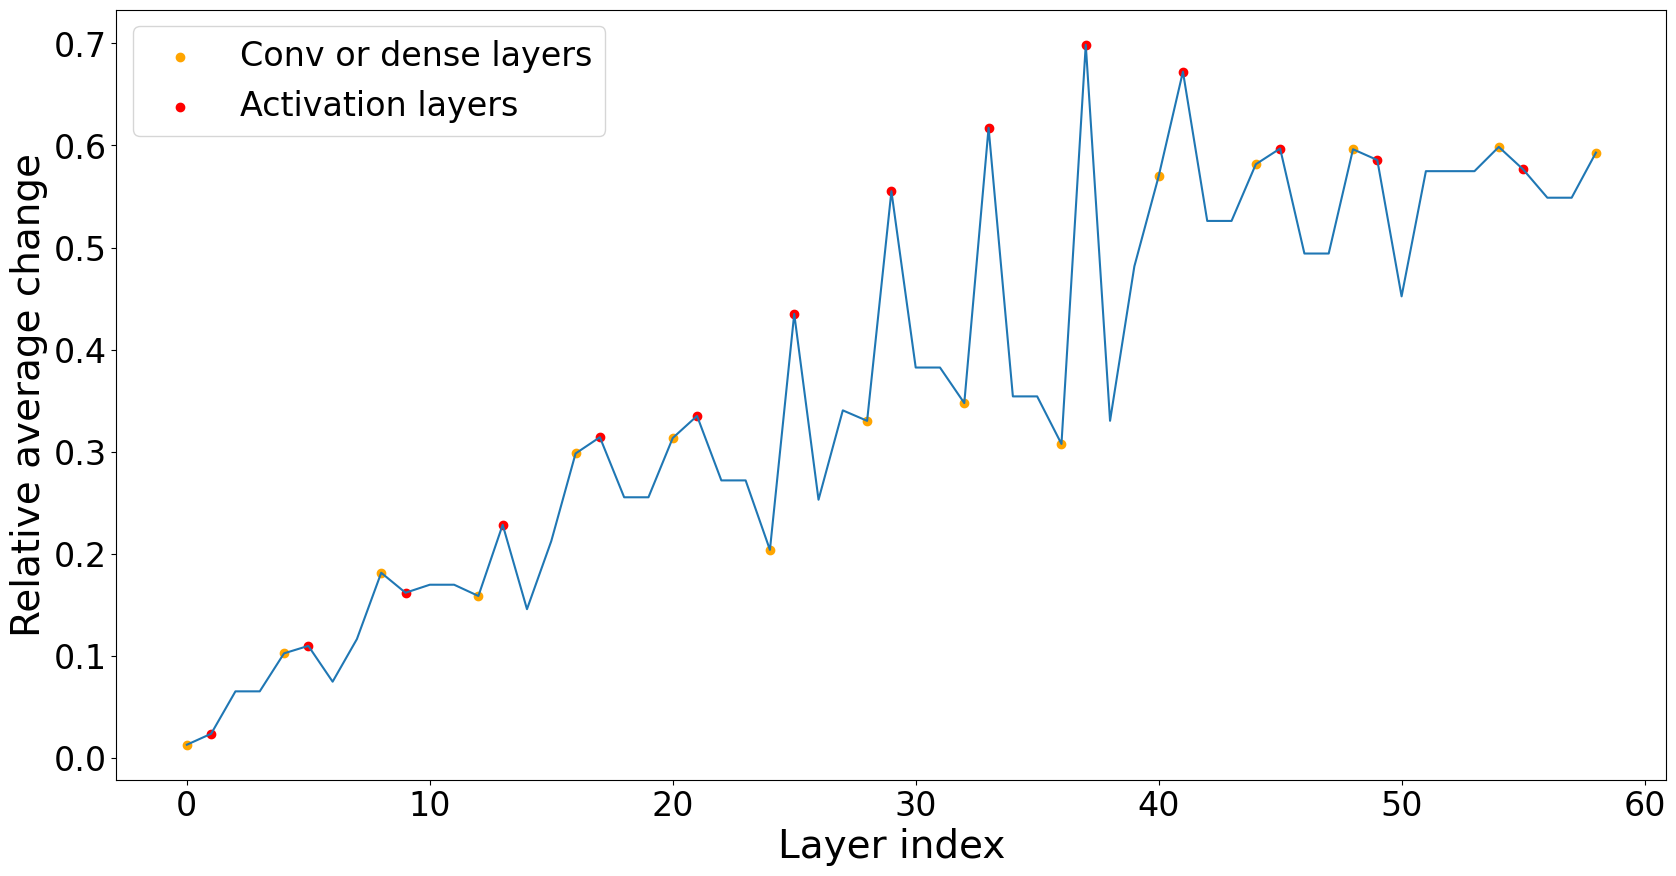

In [186]:
FONTSIZE = 28
FONTSIZE_AXIS = 24
FONTSIZE_LEGEND = 24
plt.figure(figsize=(20,10))
plt.xlabel("Layer index", fontsize=FONTSIZE)
plt.ylabel("Relative average change", fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE_AXIS)
plt.yticks(fontsize=FONTSIZE_AXIS)
plt.plot(avg_changes)
plt.scatter(indices_linear, avg_changes_linear, c="orange", label="Conv or dense layers")
plt.scatter(indices_activation, avg_changes_activation, c="red", label="Activation layers")
plt.legend(fontsize=FONTSIZE_LEGEND)

<h3> Train LGB on intermediary output </h3>

In [187]:
layer_names = [model.model.layers[x].get_config()['name'] for x in range(len(model.model.layers))]

In [44]:
LAYER_IDX = 40

SLICE_SIZE = 200

train_features = []
for i in tqdm(range(len(x_train) // SLICE_SIZE)):
    left = i * SLICE_SIZE
    right = left + SLICE_SIZE
    batch_layer_outputs = get_layer_outputs(model, x_train[left:right], LAYER_IDX)
    batch_layer_outputs = np.reshape(batch_layer_outputs, (SLICE_SIZE, -1))
    train_features.append(batch_layer_outputs)

train_features = np.vstack(train_features)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:08<00:00,  3.64it/s]


In [45]:
X_train_stack, X_val, y_train_stack, y_val = train_test_split(train_features, y_train, test_size=0.1, random_state=42)

In [46]:
y_train_stack = np.argmax(y_train_stack, axis=1)
y_val = np.argmax(y_val, axis=1)

In [47]:
RUN_OPTUNA = False

In [48]:
best_params = {
    'lambda_l1': 0.8021389627616706, 
    'lambda_l2': 9.818860936043825, 
    'num_leaves': 135, 
    'feature_fraction': 0.6016921652574784, 
    'bagging_fraction': 0.9902711576251494, 
    'bagging_freq': 1, 
    'min_child_samples': 81
}

In [49]:
def objective(trial):
    train_x, test_x, train_y, test_y = X_train_stack, X_val, y_train_stack, y_val
    dtrain = lgb.Dataset(train_x, label=train_y)
 
    param = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': 100,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'verbose': -1,
    }
    gbm = lgb.train(param, dtrain, verbose_eval=False)
    preds = np.argmax(gbm.predict(test_x), axis=1)
    accuracy = sklearn.metrics.accuracy_score(test_y, preds)
    return accuracy
 
if RUN_OPTUNA:
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100, timeout=7200)

    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)
    best_params = study.best_trial.params

In [50]:
params = {
    **best_params,
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 100,
    'verbose': -1,
}

In [70]:
TUNE_NUM_ITERS = False
num_iters_full_train = 1000

In [71]:
if TUNE_NUM_ITERS:
    dtrain = lgb.Dataset(X_train_stack, y_train_stack)
    dval = lgb.Dataset(X_val, y_val)

    lgb_stack_interm = lgb.train(params, train_set=dtrain, valid_sets=[dval], early_stopping_rounds=30, num_boost_round=1000, verbose_eval=10)
    
    num_iters_full_train = lgb_stack_interm.best_iteration

In [73]:
X_train_stack_full = np.vstack([X_train_stack, X_val])
y_train_stack_full = np.concatenate((y_train_stack, y_val))

In [74]:
dtrain_full = lgb.Dataset(X_train_stack_full, y_train_stack_full)
lgb_stack = lgb.train(params, train_set=dtrain_full)

In [75]:
(np.argmax(lgb_stack.predict(X_val), axis=1) == y_val).mean()

0.9998

<h3> Run stacked model on test data </h3>

In [76]:
len(x_test)

10000

In [77]:
LAYER_IDX = 40

SLICE_SIZE = 200

test_features = []
for i in tqdm(range(len(x_test) // SLICE_SIZE)):
    left = i * SLICE_SIZE
    right = left + SLICE_SIZE
    batch_layer_outputs = get_layer_outputs(model, x_test[left:right], LAYER_IDX)
    batch_layer_outputs = np.reshape(batch_layer_outputs, (SLICE_SIZE, -1))
    test_features.append(batch_layer_outputs)

test_features = np.vstack(test_features)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.46it/s]


In [87]:
test_pred_lgb = lgb_stack.predict(test_features)

In [88]:
stack_model_correct_test_indices = (np.argmax(test_pred_lgb, axis=1) == np.argmax(y_test, axis=1))

In [89]:
stack_model_test_accuracy = stack_model_correct_test_indices.mean()

In [91]:
stack_model_test_total_correct = stack_model_correct_test_indices.sum()

In [92]:
x_test_correct_stack = x_test[stack_model_correct_test_indices]
y_test_correct_stack = y_test[stack_model_correct_test_indices]

In [96]:
class StackedModel():
    def __init__(self, deep_model, layer_idx, lgb_model):
        self.deep_model = deep_model
        self.layer_idx = layer_idx
        self.lgb_model = lgb_model
        
        
    def predict_intermediary(self, batch_img):
        batch_size = len(batch_img)
        batch_layer_outputs = get_layer_outputs(self.deep_model, batch_img, self.layer_idx)
        batch_layer_outputs = np.reshape(batch_layer_outputs, (batch_size, -1))
        return batch_layer_outputs
    
    def predict(self, batch_img, verbose=False):
        batch_layer_outputs = self.predict_intermediary(batch_img)
        
        lgb_output = self.lgb_model.predict(batch_layer_outputs)
        return lgb_output

In [97]:
stacked_model = StackedModel(model, LAYER_IDX, lgb_stack)

In [98]:
len(model.model.layers)

60

<h3> Run EvoBA against the stacked model </h3>

In [204]:
adv_evo_strategy_lgb = {}
queries_lgb = []
perturbed_images_lgb = 0
failed_images_lgb = 0

for index in tqdm(range(SIZE)):
    if stack_model_correct_test_indices[index]:
        img = x_test[index]
        label = np.argmax(y_test[index])
        adv_evo_strategy_lgb[index] = EvoStrategy.AdversarialPerturbationEvoStraegy(
            model=stacked_model,
            img=img,
            label=label,
            generation_size=GENERATION_SIZE, 
            one_step_perturbation_pixel_count=PIXEL_COUNT,
            verbose=VERBOSE,
            zero_one_scale=False
        )

        no_steps = adv_evo_strategy_lgb[index].run_adversarial_attack(steps=STEPS)
        if adv_evo_strategy_lgb[index].is_perturbed() and no_steps > 0:
            perturbed_images_lgb += 1
            queries_lgb.append(adv_evo_strategy_lgb[index].queries)
        else:
            failed_images_lgb += 1
            queries_lgb.append(-1)

        adv_evo_strategy_lgb[index].run_adversarial_attack(steps=STEPS)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


In [188]:
np.max(queries)

1051

In [191]:
# preds_stacked_model_on_test_correct = np.argmax(stacked_model.predict(x_test_correct_stack), axis=1)

In [192]:
# lgb_acc_on_test_correct = sum(preds_stacked_model_on_test_correct == np.argmax(y_test_correct_stack, axis=1))

In [193]:
# lgb_acc_on_test_correct

In [194]:
# print(lgb_acc_on_test_correct)

In [195]:
# extrapolate_total_perturbed_lgb = perturbed_images_lgb / lgb_acc_on_test_correct * stack_model_test_total_correct

In [196]:
np.max(queries_lgb)

1651

In [209]:
avg_queries_succ = np.array(queries)[np.array(queries)>0].mean()
avg_queries_succ_lgb = np.array(queries_lgb)[np.array(queries_lgb)>0].mean()

print(
    "Stack model perturbed images:", perturbed_images_lgb, f"out of {perturbed_images_lgb + failed_images_lgb}",
    "correctly classified ones",
    f"i.e {perturbed_images_lgb / (perturbed_images_lgb + failed_images_lgb) * 100}%"
)
print(
    "Deep model perturbed images:", perturbed_images, f"out of {perturbed_images + failed_images}",
    f"i.e {perturbed_images / (perturbed_images + failed_images) * 100}%\n"
)

print("Stack model avg succ query:", avg_queries_succ)
print("Deep model avg succ query:", avg_queries_succ_lgb, "\n")

print("Stack model accuracy:", stack_model_test_accuracy)
print("Deep model accuracy:", acc, "\n")

Stack model perturbed images: 59 out of 68 correctly classified ones i.e 86.76470588235294%
Deep model perturbed images: 71 out of 71 i.e 100.0%

Stack model avg succ query: 227.90140845070422
Deep model avg succ query: 248.11864406779662 

Stack model accuracy: 0.6984
Deep model accuracy: 0.7048 



<h4> Plot perturbed accuracy as a function of queries </h4>

In [250]:
queries_lgb.sort()
queries.sort()

queries_lgb_array = np.array(queries_lgb)
queries_lgb_array = queries_lgb_array[queries_lgb_array > 0]

queries_array = np.array(queries)
queries_array = queries_array[queries_array > 0]

intermediary_accuracies = []
intermediary_lgb_accuracies = []
query_thresholds = []

for i in range(0, 2000, 50):
    curr_perturbed_count = np.sum(queries_array < i)
    curr_lgb_perturbed_count = np.sum(queries_lgb_array < i)
    
    intermediary_accuracies.append((perturbed_images + failed_images - curr_perturbed_count)/SIZE)
    intermediary_lgb_accuracies.append((perturbed_images_lgb + failed_images_lgb - curr_lgb_perturbed_count)/SIZE)
    query_thresholds.append(i)

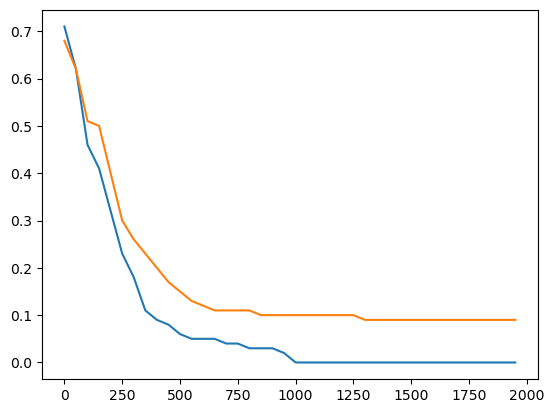

In [251]:
plt.plot(query_thresholds, intermediary_accuracies)
plt.plot(query_thresholds, intermediary_lgb_accuracies)

In [295]:
len(adv_evo_strategy_lgb)

68

In [311]:
common_perturbed_indices = []
for i in range(SIZE):
    if (i in adv_evo_strategy) and (i in adv_evo_strategy_lgb):
        if adv_evo_strategy[i].is_perturbed() and adv_evo_strategy_lgb[i].is_perturbed():
            common_perturbed_indices.append(i)

In [312]:
adv_evo_strategy_deep_shared = [adv_evo_strategy[x] for x in common_perturbed_indices]
adv_evo_strategy_lgb_shared = [adv_evo_strategy_lgb[x] for x in common_perturbed_indices]

In [313]:
evoba_stats_deep_shared = utils.get_evoba_stats(adv_evo_strategy_deep_shared)

In [314]:
evoba_stats_lgb_shared = utils.get_evoba_stats(adv_evo_strategy_lgb_shared)

In [315]:
utils.print_evoba_stats(evoba_stats_deep_shared)


EvoBA STATS (L0 attack)
____________________
Perturbed successfully 57/57 images
Average query count: 181.52631578947367
Average l0 distance: 17.982456140350877
Average l2 distance per pixel: 0.0005949203781747343

Median query count: 181.0
Median l0 dist: 18.0

Max query count: 481
Max l0 dist: 48
____________________



In [316]:
utils.print_evoba_stats(evoba_stats_lgb_shared)


EvoBA STATS (L0 attack)
____________________
Perturbed successfully 57/57 images
Average query count: 338.36842105263156
Average l0 distance: 32.73684210526316
Average l2 distance per pixel: 0.000699345004968332

Median query count: 211.0
Median l0 dist: 21.0

Max query count: 4771
Max l0 dist: 443
____________________



<h4> Visualise robust vs non-robust image embeddings [deprecated for now, to review after changes in the way EvoBA loops are ran] </h4>

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
test_interm_features = stacked_model.predict_intermediary(x_test_correct)

In [ ]:
# TODO: try UMAP
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(test_interm_features)

In [ ]:
X_embedded_x = [x[0] for x in X_embedded]
X_embedded_y = [x[1] for x in X_embedded]

In [ ]:
y_test_class = np.argmax(y_test_correct, axis=1)

In [ ]:
# Only plot first couple classes embeddings
class_plot_list = list(range(100))
class_to_idx_dict = {c: i for i, c in enumerate(class_plot_list)}
sample_mask = [x in class_plot_list for x in y_test_class]

X_embedded_x_sample = np.array(X_embedded_x)[sample_mask]
X_embedded_y_sample = np.array(X_embedded_y)[sample_mask]
y_test_sample = y_test_correct[sample_mask]
y_test_class_sample = np.argmax(y_test_sample, axis=1)

# color_list = [class_to_idx_dict[c] for c in y_test_class_sample]
# color_list = [1 for c in y_test_class_sample]
color_list = [int(class_to_idx_dict[c]/20) for c in y_test_class_sample]

In [ ]:
mask_hard_perturbed_lgb = np.logical_or(np.array(queries_lgb) > 10000, np.array(queries_lgb) < 0)
mask_easy_perturbed_lgb = np.logical_and(np.array(queries_lgb) > 0, np.array(queries_lgb) < 50)

In [ ]:
import random

In [ ]:
mask_robust = np.logical_and(sample_mask[:SIZE], mask_hard_perturbed_lgb)

X_embedded_x_sample_robust = np.array(X_embedded_x)[:SIZE][mask_robust]
X_embedded_y_sample_robust = np.array(X_embedded_y)[:SIZE][mask_robust]
y_test_sample_robust = y_test_correct[:SIZE][mask_robust]
y_test_class_sample_robust = np.argmax(y_test_sample_robust, axis=1)

# color_list_robust = [class_to_idx_dict[c] + 10 for c in y_test_class_sample_robust]
# color_list_robust = [int(class_to_idx_dict[c]/50) for c in y_test_class_sample_robust]
color_list_robust = [0 for c in y_test_class_sample_robust]

In [ ]:
mask_not_robust = np.logical_and(sample_mask[:SIZE], mask_easy_perturbed_lgb)

X_embedded_x_sample_not_robust = np.array(X_embedded_x)[:SIZE][mask_not_robust]
X_embedded_y_sample_not_robust = np.array(X_embedded_y)[:SIZE][mask_not_robust]
y_test_sample_not_robust = y_test_correct[:SIZE][mask_not_robust]
y_test_class_sample_not_robust = np.argmax(y_test_sample_not_robust, axis=1)

color_list_not_robust = [class_to_idx_dict[c] + 10 for c in y_test_class_sample_not_robust]
color_list_not_robust = [0 for c in y_test_class_sample_not_robust]

In [ ]:
len(X_embedded_x_sample)

7048

In [ ]:
len(X_embedded_x_sample_not_robust)

11

In [ ]:
len(X_embedded_x_sample_robust)

12

In [ ]:
len(queries_lgb)

100

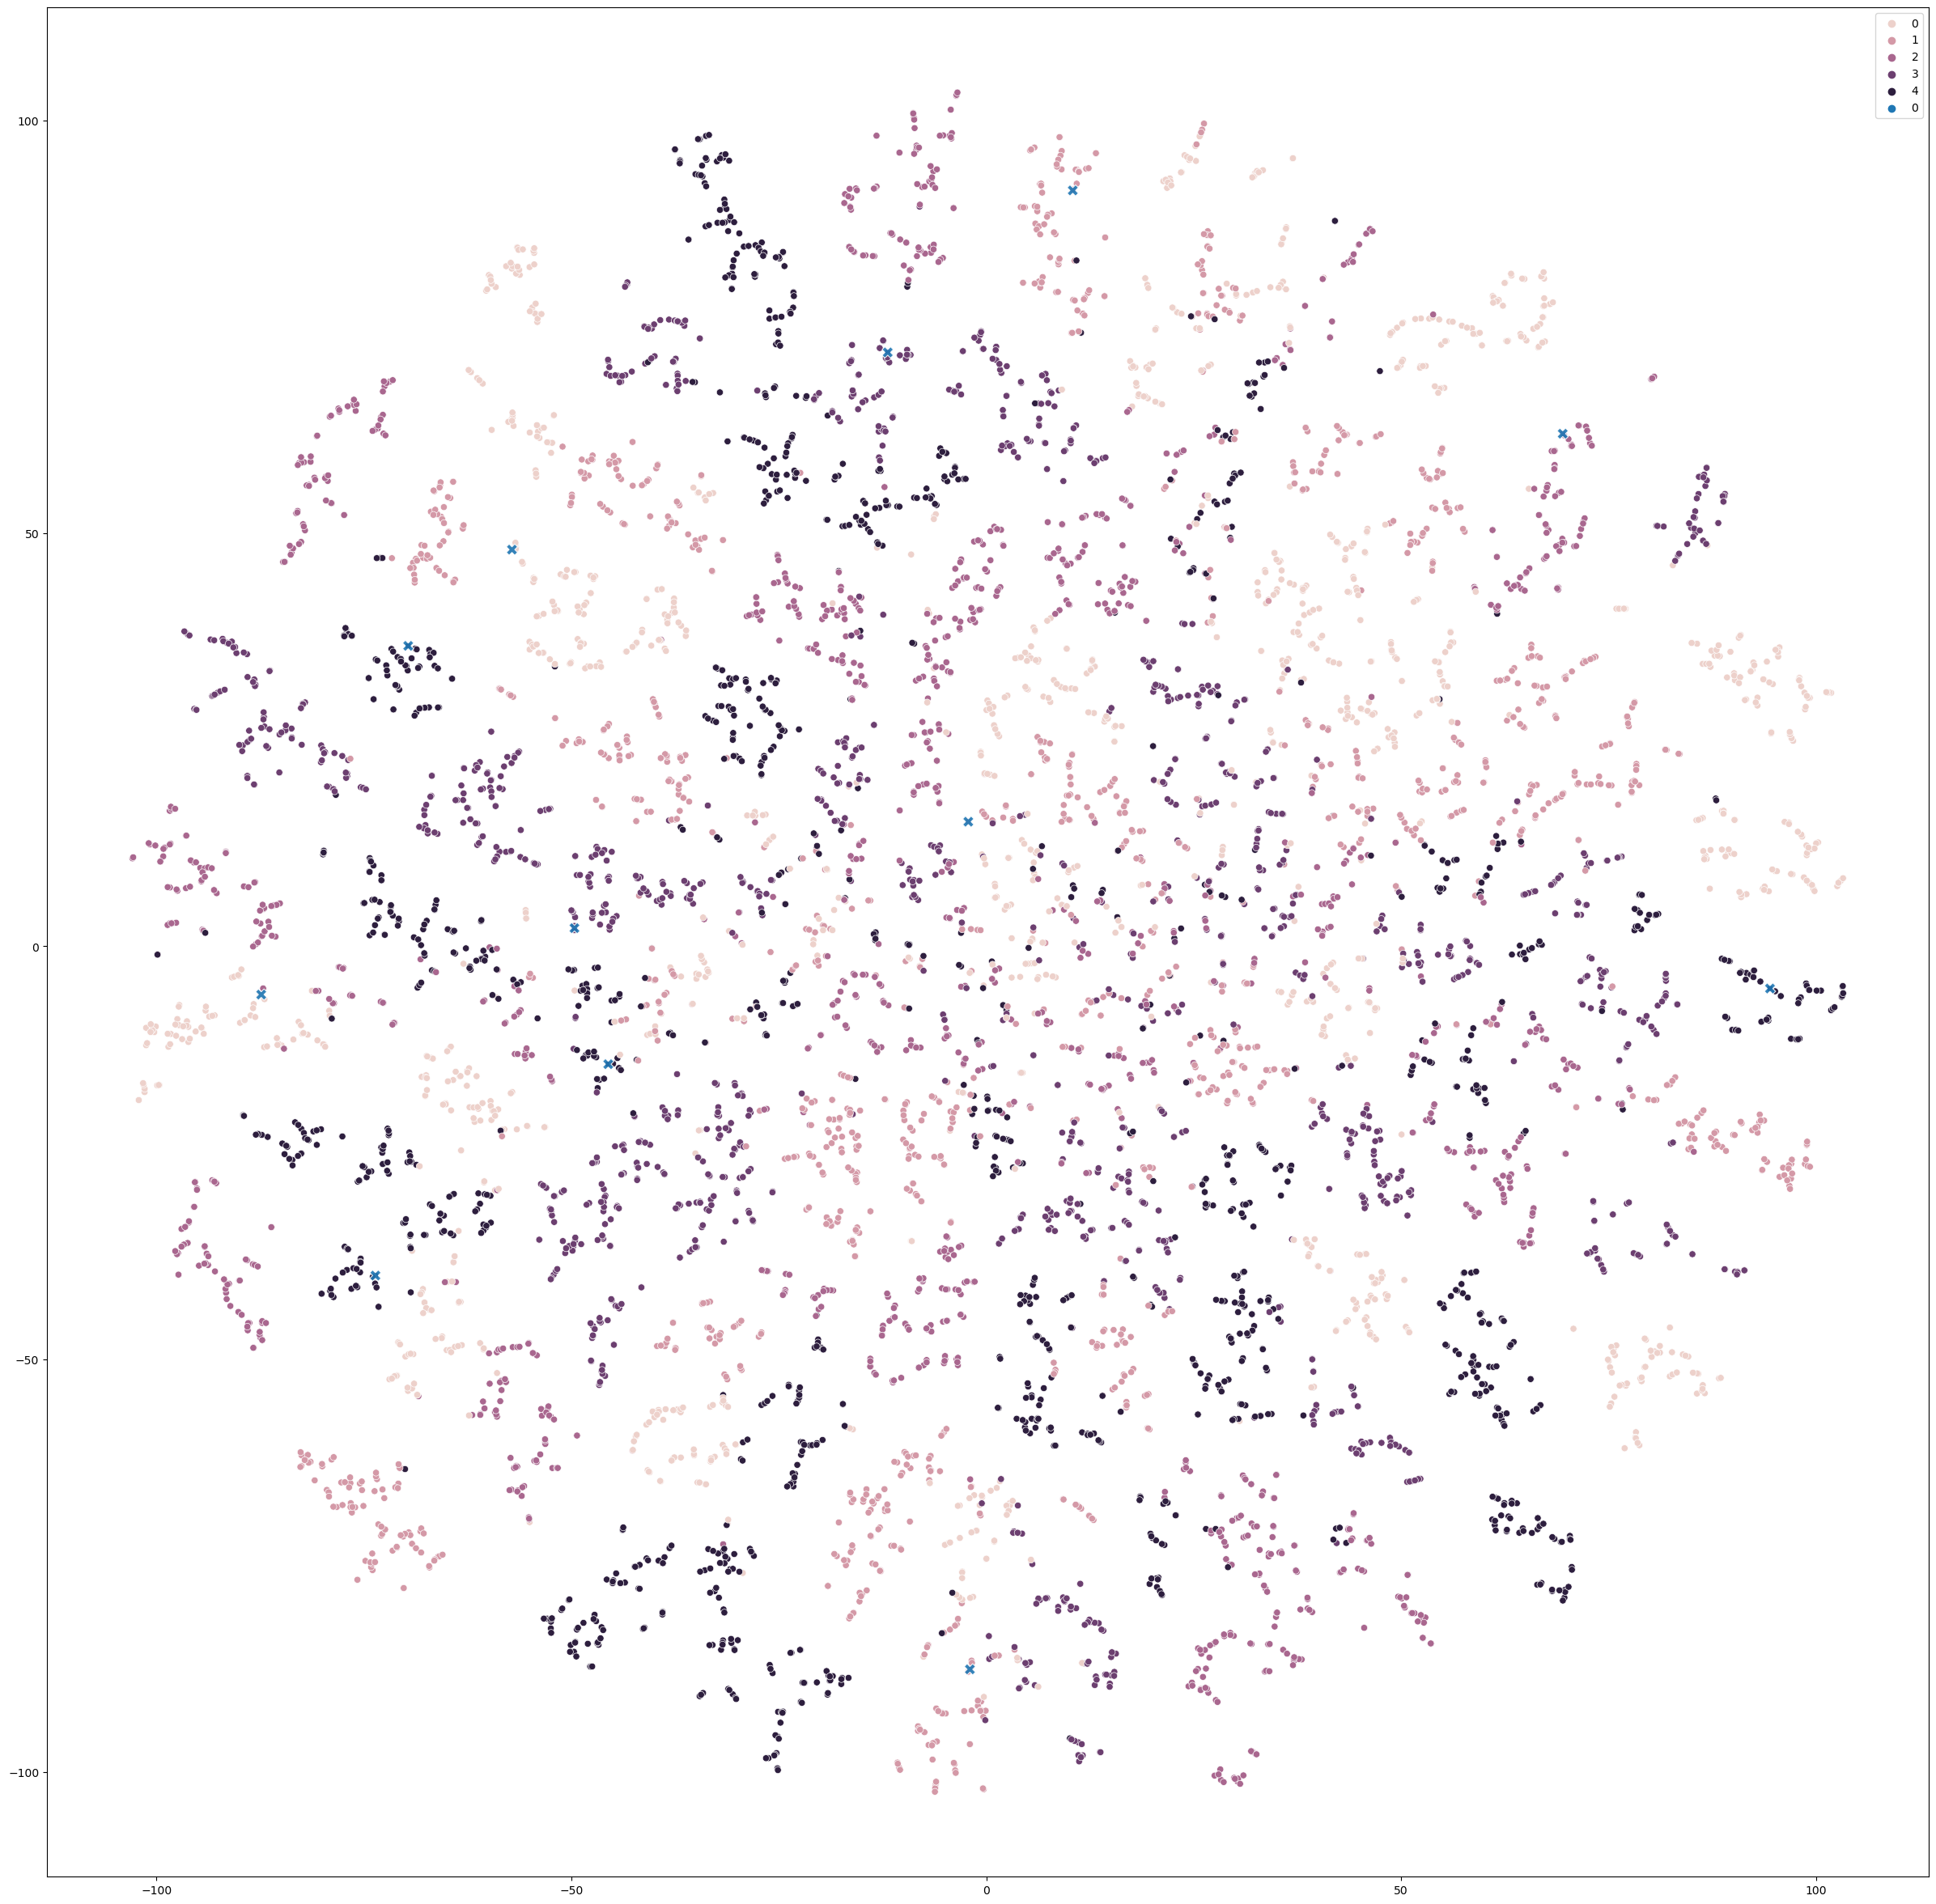

In [ ]:
plt.figure(figsize=(30,30))
sns.scatterplot(x=X_embedded_x_sample, y=X_embedded_y_sample, hue=color_list)
sns.scatterplot(x=X_embedded_x_sample_robust, y=X_embedded_y_sample_robust, hue=color_list_robust, marker="X", s=100, alpha=0.9)
# sns.scatterplot(x=X_embedded_x_sample_not_robust, y=X_embedded_y_sample_not_robust, hue=color_list_not_robust, marker="X", s=100, alpha=0.9)
plt.show()

In [ ]:
mask_hard_perturbed_lgb = np.logical_or(np.array(queries_lgb) > 1000, np.array(queries_lgb) <0)

In [ ]:
mask_hard_perturbed = np.logical_or(np.array(queries) > 1000, np.array(queries)<0)

In [ ]:
mask_correct_stack_and_deep = (np.argmax(stacked_model.predict(x_test_correct), axis=1) == np.argmax(y_test_correct, axis=1))

In [ ]:
x_test_intersection_correct = x_test_correct[mask_correct_stack_and_deep]
y_test_intersection_correct = y_test_correct[mask_correct_stack_and_deep]

In [ ]:
len(x_test_intersection_correct)

6627

In [ ]:
j = 0
adv_evo_strategy_intersection_deep = {}
for i in range(len(adv_evo_strategy)):
    if mask_correct_stack_and_deep[i] and adv_evo_strategy_lgb[i].is_perturbed():
        adv_evo_strategy_intersection_deep[j] = adv_evo_strategy[i]
        j = j + 1

In [ ]:
j = 0
adv_evo_strategy_intersection_lgb = {}
for i in range(len(adv_evo_strategy_lgb)):
    if mask_correct_stack_and_deep[i] and adv_evo_strategy_lgb[i].is_perturbed():
        adv_evo_strategy_intersection_lgb[j] = adv_evo_strategy_lgb[i]
        j = j + 1

In [ ]:
evoba_stats_deep = utils.get_evoba_stats(adv_evo_strategy_intersection_deep)

In [ ]:
evoba_stats_lgb = utils.get_evoba_stats(adv_evo_strategy_intersection_lgb)

In [ ]:
utils.print_evoba_stats(evoba_stats_deep)


EvoBA STATS (L0 attack)
____________________
Perturbed successfully 84/84 images
Average query count: 242.07142857142858
Average l0 distance: 24.047619047619047
Average l2 distance per pixel: 0.0006593095835258188

Median query count: 166.0
Median l0 dist: 16.5

Max query count: 1321
Max l0 dist: 129
____________________



In [ ]:
utils.print_evoba_stats(evoba_stats_lgb)


EvoBA STATS (L0 attack)
____________________
Perturbed successfully 84/84 images
Average query count: 361.7142857142857
Average l0 distance: 35.32142857142857
Average l2 distance per pixel: 0.0007132996796290444

Median query count: 181.0
Median l0 dist: 18.0

Max query count: 3571
Max l0 dist: 333
____________________



In [141]:
len(evoba_stats_lgb["queries_succ"])

6135

(array([2855., 4059., 4715., 5068., 5299., 5413., 5545., 5618., 5665.,
        5719., 5761., 5792., 5824., 5841., 5865., 5883., 5907., 5921.,
        5940., 5956., 5963., 5970., 5982., 5998., 6004., 6012., 6021.,
        6024., 6029., 6037., 6045., 6055., 6056., 6060., 6065., 6072.,
        6077., 6085., 6094., 6099., 6104., 6106., 6111., 6120., 6124.,
        6127., 6129., 6130., 6130., 6135.]),
 array([  31. ,  125.8,  220.6,  315.4,  410.2,  505. ,  599.8,  694.6,
         789.4,  884.2,  979. , 1073.8, 1168.6, 1263.4, 1358.2, 1453. ,
        1547.8, 1642.6, 1737.4, 1832.2, 1927. , 2021.8, 2116.6, 2211.4,
        2306.2, 2401. , 2495.8, 2590.6, 2685.4, 2780.2, 2875. , 2969.8,
        3064.6, 3159.4, 3254.2, 3349. , 3443.8, 3538.6, 3633.4, 3728.2,
        3823. , 3917.8, 4012.6, 4107.4, 4202.2, 4297. , 4391.8, 4486.6,
        4581.4, 4676.2, 4771. ]),
 [<matplotlib.patches.Polygon at 0x78ec248cd0>])

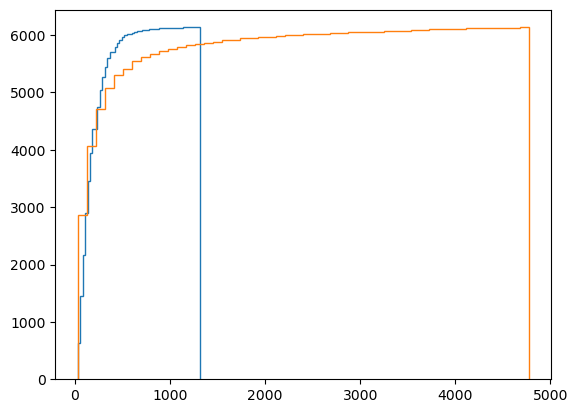

In [144]:
plt.hist(evoba_stats_deep["queries_succ"], histtype="step", cumulative=True, bins=50)
plt.hist(evoba_stats_lgb["queries_succ"], histtype="step", cumulative=True, bins=50)

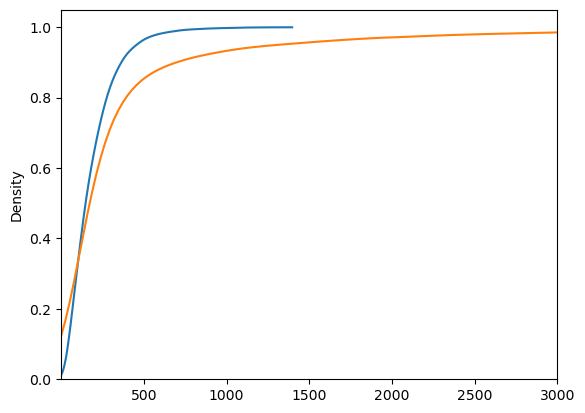

In [126]:
plt.plot()
plt.xlim(1,3000)
kde_plot_deep = sns.kdeplot(evoba_stats_deep["queries_succ"], cumulative=True)
kde_plot_lgb = sns.kdeplot(evoba_stats_lgb["queries_succ"], cumulative=True)

Bbox([[-270.36623649028354, 0.0], [5072.366236490284, 0.9998576106082278]])

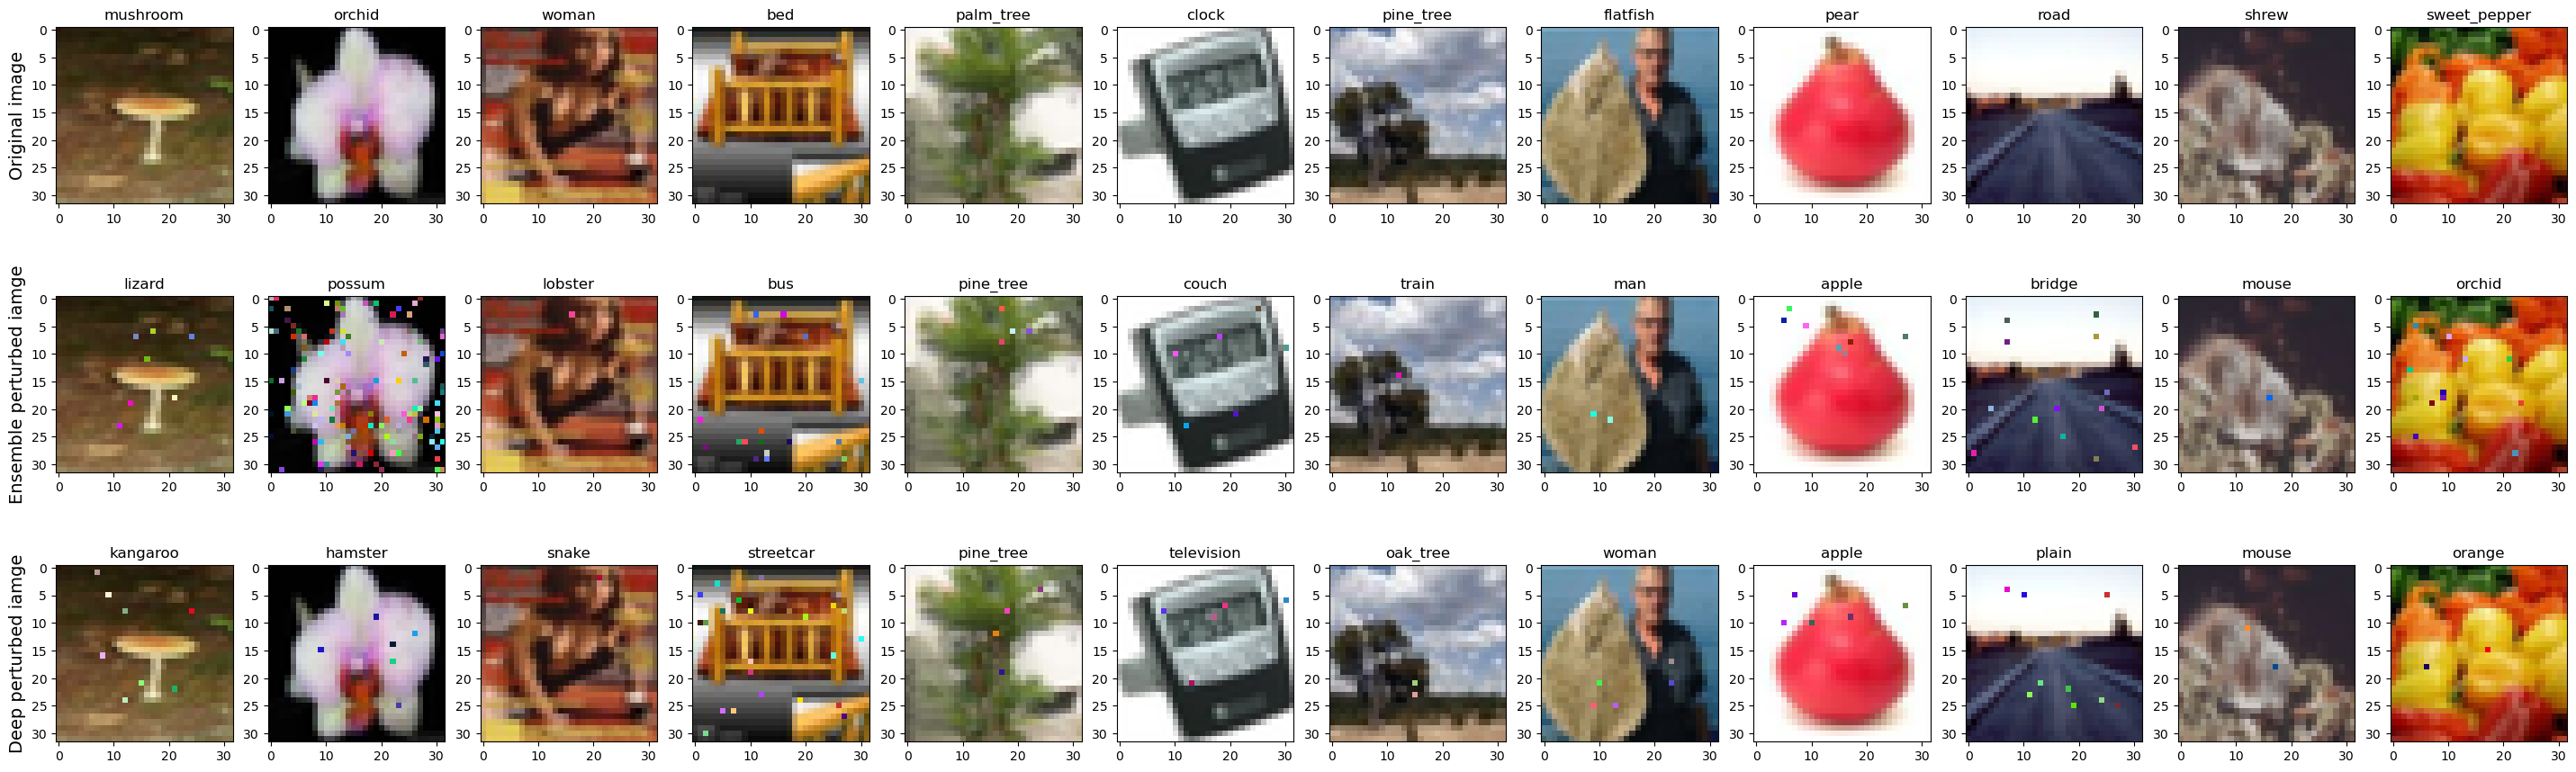

In [185]:
NUM_IMG_PLOT_COMPARISON = 12
fig, axs = plt.subplots(nrows=3, ncols=NUM_IMG_PLOT_COMPARISON, figsize=(3 * NUM_IMG_PLOT_COMPARISON, 11))
for i in range(NUM_IMG_PLOT_COMPARISON):
    IDX = random.randint(0, len(adv_evo_strategy_intersection_lgb))
    
    original_label = adv_evo_strategy_intersection_deep[IDX].label
    
    axs[0][i].set_title(f"{cifar_100_classes[original_label]}")
    axs[0][i].imshow(adv_evo_strategy_intersection_deep[IDX].img)
    
    axs[0][0].set_ylabel("Original image", fontsize=14)

    
    pred_class_lgb = stacked_model.predict(np.array([adv_evo_strategy_intersection_lgb[IDX].get_best_candidate()]))[0]
    pred_class_lgb = np.argmax(pred_class_lgb)
    axs[1][i].set_title(f"{cifar_100_classes[pred_class_lgb]}")
    axs[1][i].imshow(adv_evo_strategy_intersection_lgb[IDX].get_best_candidate())
    
    axs[1][0].set_ylabel("Ensemble perturbed iamge", fontsize=14)

    
    pred_class_deep = model.predict(np.array([adv_evo_strategy_intersection_deep[IDX].get_best_candidate()]))[0]
    pred_class_deep = np.argmax(pred_class_deep)
    axs[2][i].set_title(f"{cifar_100_classes[pred_class_deep]}")
    axs[2][i].imshow(adv_evo_strategy_intersection_deep[IDX].get_best_candidate())

    axs[2][0].set_ylabel("Deep perturbed iamge", fontsize=14)


Text(0.5, 1.0, 'Perturbed image \nplate')

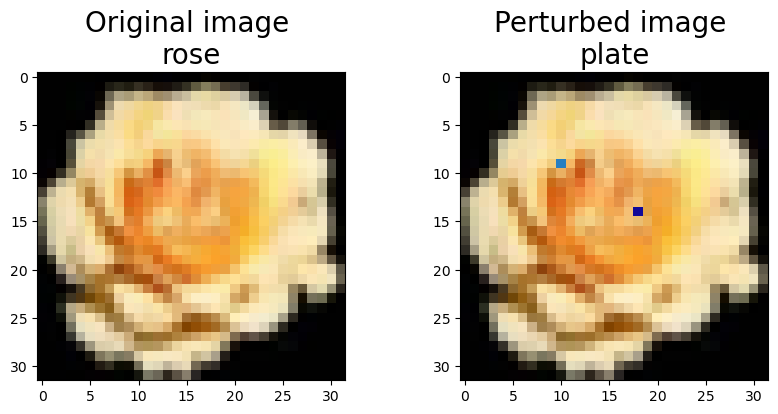

In [190]:
IMG_IDX = 13

correct_class_name = cifar_100_classes[np.argmax(y_test_correct[IMG_IDX])]

local_pred = np.argmax(model.predict(np.array([adv_evo_strategy[IMG_IDX].get_best_candidate()]))[0])
perturbed_class_name = cifar_100_classes[local_pred]

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].imshow(x_test_correct[IMG_IDX])
axs[0].set_title(f"Original image \n{correct_class_name}", fontsize=20)

axs[1].imshow(adv_evo_strategy[IMG_IDX].get_best_candidate())
axs[1].set_title(f"Perturbed image \n{perturbed_class_name}", fontsize=20)

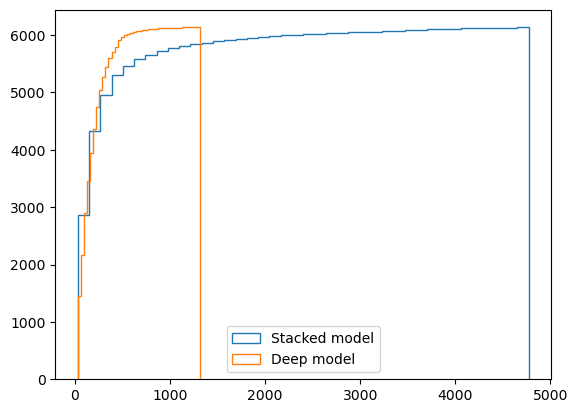

In [216]:
plt.hist(evoba_stats_lgb["queries_succ"], histtype="step", bins=40, cumulative=True, label="Stacked model")
plt.hist(evoba_stats_deep["queries_succ"], histtype="step", bins=40, cumulative=True, label="Deep model")
plt.legend()

In [235]:
querry_succ_array_lgb = np.array(evoba_stats_lgb["queries_succ"])
querry_succ_array_deep = np.array(evoba_stats_deep["queries_succ"])

query_limits =[]
succ_rates_lgb = []
succ_rates_deep = []

for query_limit in [200, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000]:
    succ_rate_lgb = np.mean(querry_succ_array_lgb < query_limit)
    succ_rate_deep = np.mean(querry_succ_array_deep < query_limit)

    succ_rates_lgb.append(succ_rate_lgb)
    succ_rates_deep.append(succ_rate_deep)
    
    query_limits.append(query_limit)

In [236]:
df_succ_rates = pd.DataFrame([query_limits, succ_rates_lgb, succ_rates_deep]).T.rename(columns={0: "query_count", 1: "LGB_SR", 2: "deep_SR"})

In [237]:
df_succ_rates

,query_count,LGB_SR,deep_SR
0,200.0,0.608476,0.643847
1,500.0,0.863733,0.964955
2,750.0,0.908720,0.992339
3,1000.0,0.934963,0.998044
4,1500.0,0.956968,1.000000
5,2000.0,0.971801,1.000000
6,3000.0,0.985656,1.000000
7,4000.0,0.995273,1.000000
8,5000.0,1.000000,1.000000
